# UE Computer Vision | Project : Visual tracking of video objects

**Students:**
- Maria FLORENZA LAMBERTI - maria.florenza-lamberti@imt-atlantique.net
- Dely ARDILA MEDINA - dely.ardila-medina@imt-atlantique.net
- Nhan 

---

## Import Libraries

In [2]:
import argparse
from path import Path

import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import models
from tqdm import tqdm

import torchvision.transforms as transforms
import flow_transforms
from imageio import imread, imwrite
from imageio.v2 import imread, imwrite, imsave
import numpy as np
from util import flow2rgb
import glob
import os
import time
from skimage import io, img_as_ubyte
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops

import numpy as np
import cv2
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel

---

## Data

In [17]:
img_path = 'sequences-train'
flow_path = 'sequences-train/flow'
name = 'bear'
preprocess = '_detail_enhance'

flow_files = sorted(glob.glob(os.path.join(flow_path, name + '*.npy')))
img_ext = 'bmp'
mask_ext = 'png'
img_files = sorted(glob.glob(os.path.join(img_path, name + '*.' + img_ext)))
mask_files = sorted(glob.glob(os.path.join(img_path, name + '*.' + mask_ext)))
dices_filename = 'results/dice_'+name+preprocess
fmeasures_filename = 'results/fmeasure_'+name+preprocess
centroid_dist_filename = 'results/centroid_dist_'+name+preprocess

im_begin = 1
im_end = len(img_files)

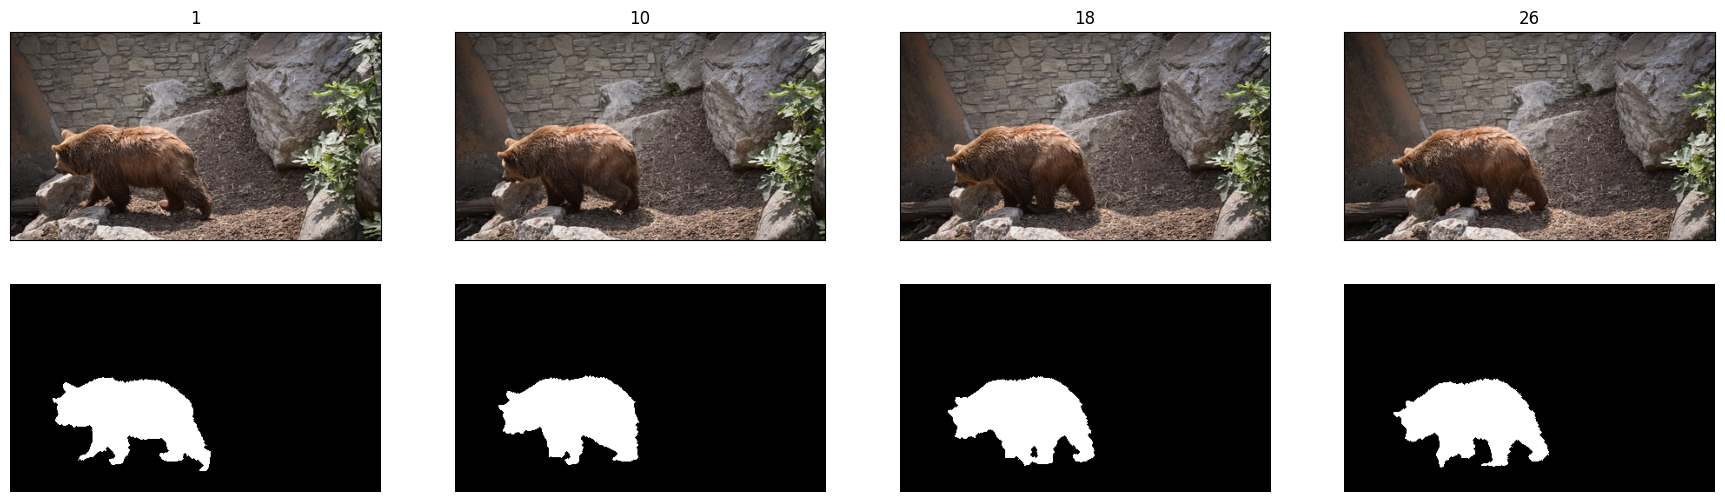

In [18]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([1,10,18,26]):
    img_current = imread('sequences-train/'+name+'-%0*d.bmp'%(3,im))
    mask_current = imread('sequences-train/'+name+'-%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

---

## Model

In [19]:
#path_to_model = "./FlowNet_Models/pytorch/flownets_EPE1.951.pth.tar"
path_to_model = "./FlowNet_Models/pytorch/flownets_EPE1.951.pth"
path_to_sequesnces = "./sequences-train/"

---

## Declare Functions

### Assesment

In [20]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [21]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

In [22]:
def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1

    return bmap

In [23]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

In [24]:
def concatenation(unary_flow, to_ref_flow):
    x0 = np.arange(unary_flow.shape[1])  # Eje X
    y0 = np.arange(unary_flow.shape[0])  # Eje Y

    # Para interpolar en 2D, usamos RegularGridInterpolator
    fx = RegularGridInterpolator((y0, x0), to_ref_flow[:,:,1], method='linear', bounds_error=False, fill_value=0)
    fy = RegularGridInterpolator((y0, x0), to_ref_flow[:,:,0], method='linear', bounds_error=False, fill_value=0)

    # Crear las mallas de los puntos
    xx, yy = np.meshgrid(x0, y0)

    # Interpolación en el flujo X e Y
    z_x = fx((yy, xx))  # Interpolación para el flujo X
    z_y = fy((yy, xx))  # Interpolación para el flujo Y

    # Combina las interpolaciones de X e Y
    result = np.stack([z_y, z_x], axis=-1)
    return result
    """
def concatenation(unary_flow, to_ref_flow):
    h, w, _ = to_ref_flow.shape
    x0 = np.arange(w)
    y0 = np.arange(h)

    xx, yy = np.meshgrid(x0, y0, indexing='xy')

    interp_fx = RegularGridInterpolator((y0, x0), to_ref_flow[..., 1], method='cubic', bounds_error=False, fill_value=None)
    interp_fy = RegularGridInterpolator((y0, x0), to_ref_flow[..., 0], method='cubic', bounds_error=False, fill_value=None)

    fx = interp_fx((yy, xx))
    fy = interp_fy((yy, xx))

    return np.stack([fy, fx], axis=-1)
"""

In [25]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask
    
def propagate_mask_direct(nb_start, nb_end, name_in_the_figure):
    # generate all the propagated masks for the direct method

    original_mask = imread(f"./sequences-train/{name_in_the_figure}-001.png")
    first_img = imread(f'./sequences-train/{name_in_the_figure}-001.bmp')
    # imwrite( f"./my_results/{name_in_the_figure}-mask_pro-001-001.png", original_mask) # For coherence when reading them later


    for i in range(nb_start+1, nb_end+1):
        flow = np.load( "./my_results/" + "direct" + name_in_the_figure + "-001-" + str(i).zfill(3) + '.npy')    
        current_mask = propagate_mask(flow, img_current= first_img, mask_begin = original_mask)

        imwrite( f"./my_results/{name_in_the_figure}-mask_pro_dir-001-"+ str(i).zfill(3) +'.png', current_mask)
        print(f"ok {name_in_the_figure}-mask_pro_dir-001-"+ str(i).zfill(3) +'.png')
    print("End of mask propagation for direct integration")


---

## Baseline method

In [26]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

In [27]:
img_begin = imread('sequences-train/'+name+'-%0*d.bmp'%(3,im_begin))
mask_begin = imread('sequences-train/'+name+'-%0*d.png'%(3,im_begin))

dices, fmeasures, centroid_dist, visu = [], [], [], []
for im in range(im_begin+1,im_end+1):
    print(im) # debug
    img_current = imread('sequences-train/'+name+'-%0*d.bmp'%(3,im))
    mask_current = imread('sequences-train/'+name+'-%0*d.png'%(3,im))
    flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
    propagation = propagate_mask(flow, img_current, mask_begin)
    imsave(name+'-prop-%0*d.png'%(3,im), img_as_ubyte(propagation))
    visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation, color=(1,0,0)))
    imsave(name+'-bound-%0*d.png'%(3,im), img_as_ubyte(visu[-1]))
    dices.append(dice_assessment(mask_current, propagation))
    fmeasures.append(db_eval_boundary(mask_current, propagation))
    centroid_dist.append(centroid_assessment(mask_current, propagation))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


## Results Visualization Individuel

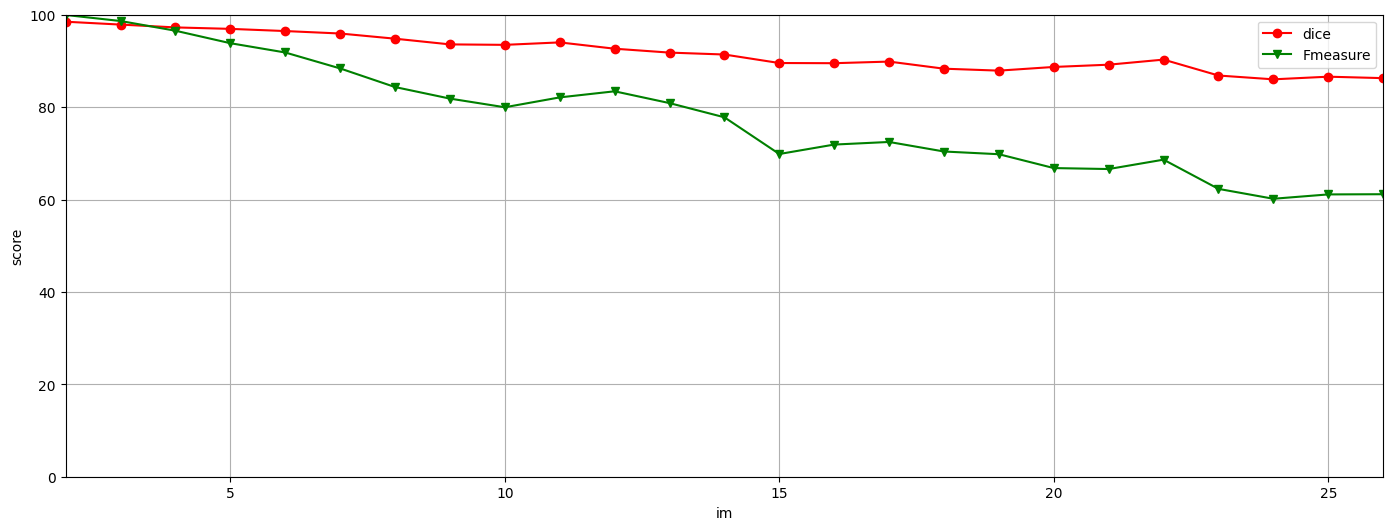

In [28]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,fmeasures,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
plt.savefig('eval.png')
plt.show()

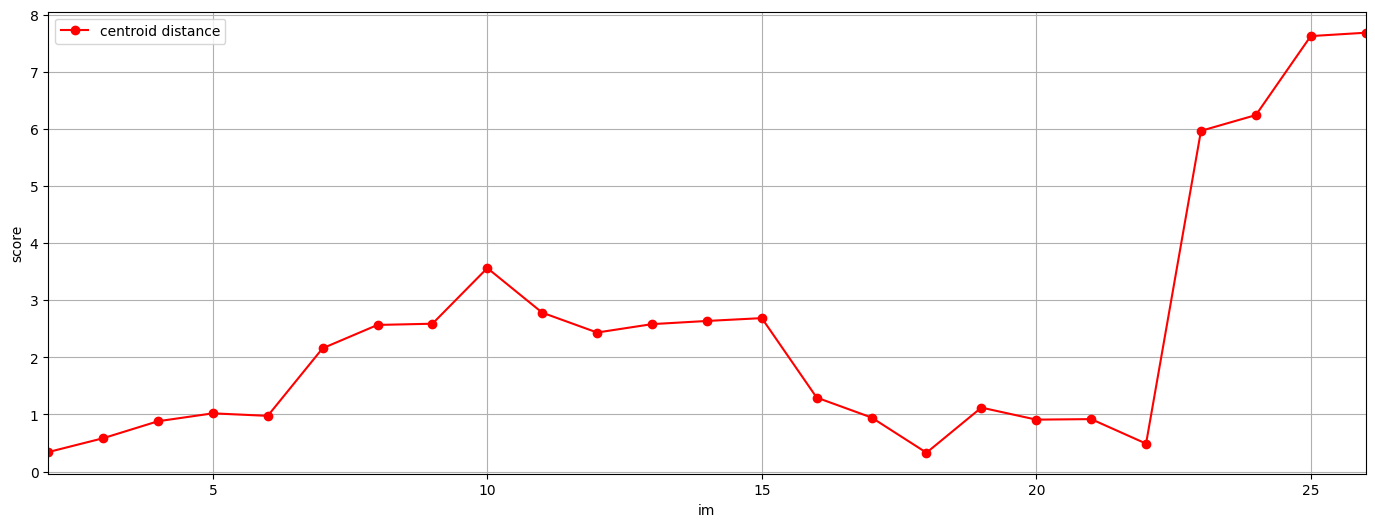

In [29]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance'])
plt.savefig('eval-centroid.png')
plt.show()

<Figure size 640x480 with 0 Axes>

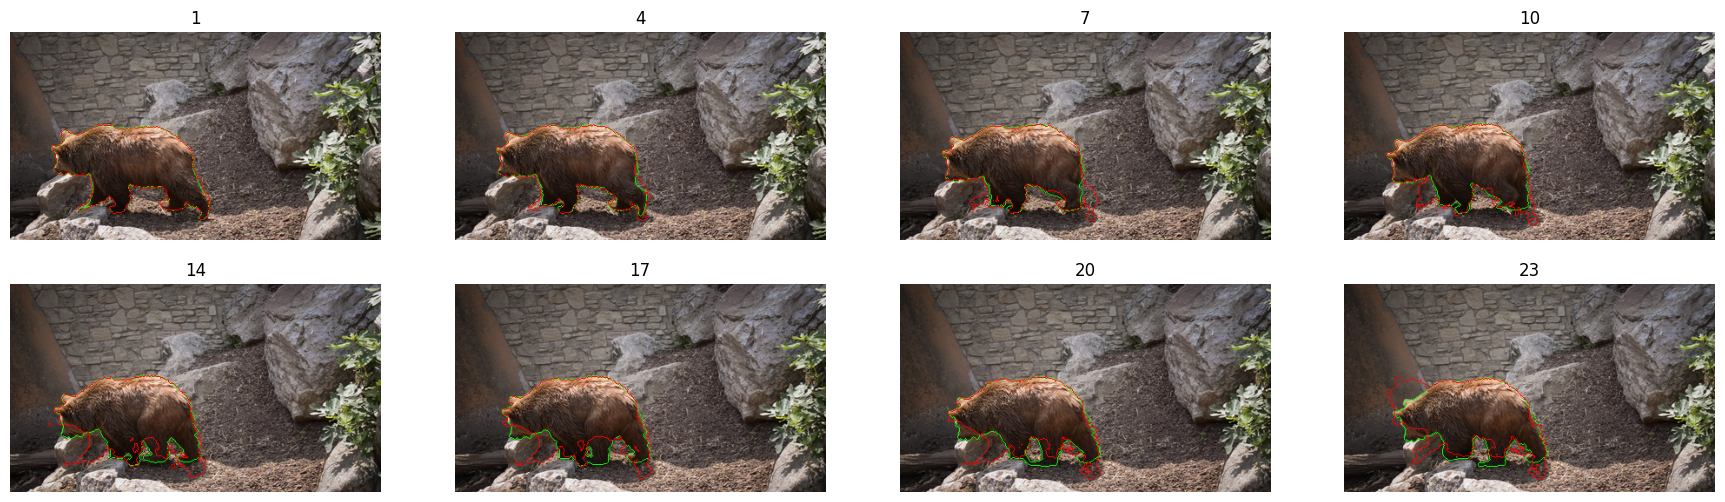

In [30]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(visu[im])
    plt.title('%i' %(im+1))
plt.show()

## Results Visualization

In [15]:
# sequential 
name = ["bear", "book", "camel", "rhino", "swan"]
im_begin = [ 1     ,  1    , 1      , 1      ,  1]  
im_end =   [ 26    ,  51   , 90     , 90     ,  50]

bear


ValueError: x and y must have same first dimension, but have shapes (25,) and (14,)

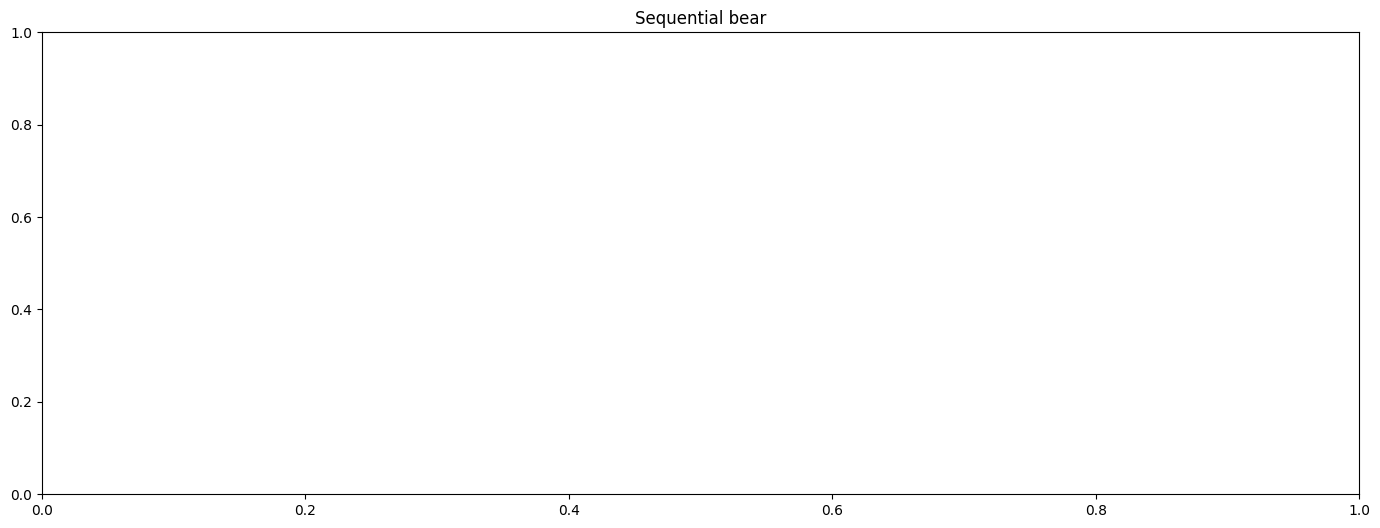

In [16]:
# Results sequential

name = ["bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end =   [ 26    ,  51   , 90     , 90     ,  50]


for i in range(len(name)):
    file_path_dice ="./my_results/"+name[i] +"-dice_seq.npy"
    file_path_fmeasures ="./my_results/"+name[i] +"-fmeasures_seq.npy"

    loaded_array_dice = np.load(file_path_dice)
    loaded_array_fmeasure = np.load(file_path_fmeasures)

    x = range(start[i]+1,end[i]+1)
    print(name[i])
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title("Sequential " + name[i])
    ax.plot(x,loaded_array_dice,marker='o',color='r')
    ax.plot(x,loaded_array_fmeasure,marker='v',color='g')
    ax.set_xlim((start[i]+1+1,end[i]+1))
    ax.set_ylim((0,100))
    ax.set_ylabel('score')
    ax.set_xlabel("im")
    ax.grid()
    ax.legend(['dice', 'Fmeasure'])
    plt.savefig('results_' + name[i] +'.png')
    plt.show()


In [16]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,fmeasures,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
plt.savefig('eval.png')
plt.show()

TypeError: can only concatenate list (not "int") to list

In [17]:
# Results sequential

name = ["bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end =   [ 26    ,  51   , 90     , 90     ,  50]


for i in range(len(name)):
    file_path_dice ="./my_results/"+name[i] +"-dice_seq.npy"
    file_path_fmeasures ="./my_results/"+name[i] +"-fmeasures_seq.npy"

    loaded_array_dice = np.load(file_path_dice)
    loaded_array_fmeasure = np.load(file_path_fmeasures)

    x = range(start[i]+1,end[i]+1)
    print(name[i])
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title("Sequential " + name[i])
    ax.plot(x,loaded_array_dice,marker='o',color='r')
    ax.plot(x,loaded_array_fmeasure,marker='v',color='g')
    ax.set_xlim((start[i]+1+1,end[i]+1))
    ax.set_ylim((0,100))
    ax.set_ylabel('score')
    ax.set_xlabel("im")
    ax.grid()
    ax.legend(['dice', 'Fmeasure'])
    plt.savefig('results_' + name[i] +'.png')
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './my_results/bear-dice_seq.npy'

In [50]:







    






def propagate_mask_direct(nb_start, nb_end, name_in_the_figure):
    # generate all the propagated masks for the direct method

    original_mask = imread(f"./sequences-train/{name_in_the_figure}-001.png")
    first_img = imread(f'./sequences-train/{name_in_the_figure}-001.bmp')
    # imwrite( f"./my_results/{name_in_the_figure}-mask_pro-001-001.png", original_mask) # For coherence when reading them later


    for i in range(nb_start+1, nb_end+1):
        flow = np.load( "./my_results/" + "direct" + name_in_the_figure + "-001-" + str(i).zfill(3) + '.npy')    
        current_mask = propagate_mask(flow, img_current= first_img, mask_begin = original_mask)

        imwrite( f"./my_results/{name_in_the_figure}-mask_pro_dir-001-"+ str(i).zfill(3) +'.png', current_mask)
        print(f"ok {name_in_the_figure}-mask_pro_dir-001-"+ str(i).zfill(3) +'.png')
    print("End of mask propagation for direct integration")



In [14]:
# calculate the dice and f-measure for the direct integration

for i in range(len(name)):
    mask = imread("./sequences-train/"+ name[i] +"-001.png")
    dice_dir, fmeasures_dir = [], []
    for j in range(start[i]+1, end[i]):
        
        mask_cur = imread("./sequences-train/"+ name[i] +"-"+ str(j).zfill(3) +".png")
        mask_predict = imread("./my_results/"+ name[i]+ "-mask_pro_dir-001-"+ str(j).zfill(3) +'.png')
        dice_dir.append(dice_assessment(mask, mask_predict))
        fmeasures_dir.append(db_eval_boundary(mask,mask_predict))
        np.save("./my_results/" + name[i] + "-dice_dir.npy", dice_dir)
        np.save("./my_results/" + name[i] + "-fmeasures_dir.npy", fmeasures_dir)

FileNotFoundError: No such file: '/media/catalina/Datos/IMT/COMPVIS/Project/ComputerVision-FlowNet/sequences-train/s-001.png'

## Sequential integration

**Inference and Evaluatinon of the results using the sequential approach**

In [28]:
name  = [ "bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end   = [ 26    ,  51   , 90     , 90     ,  50]


for i in range(len(name)):
    complete_inferece_saving_seq(start[i], end[i], name[i])

# complete_inferece_saving_seq(1,104,"cow")

# complete_inferece_saving_seq(1,26,"fish")

#complete_inferece_saving_seq(1,26,"swan")


NameError: name 'complete_inferece_saving_seq' is not defined

## Direct Integration

In [43]:
nb_start = 1
nb_end   = 50

device = set_cuda()
model, div_flow = load_model(path_to_model, device)


name  = [ "bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end   = [ 26    ,  51   , 90     , 90     ,  50]

for i in range(len(name)):
    inference_direct(start[i], end[i], name[i], device, model, div_flow)
    propagate_mask_direct(start[i], end[i], name[i])


#inference_direct(nb_start, nb_end, "swan", device, model, div_flow)
#propagate_mask_direct(nb_start, nb_end, "swan")

cpu
=> using pre-trained model 'flownets'
./my_results/directbear-001-002.npy
./my_results/directbear-001-003.npy
./my_results/directbear-001-004.npy
./my_results/directbear-001-005.npy
./my_results/directbear-001-006.npy
./my_results/directbear-001-007.npy
./my_results/directbear-001-008.npy
./my_results/directbear-001-009.npy
./my_results/directbear-001-010.npy
./my_results/directbear-001-011.npy
./my_results/directbear-001-012.npy
./my_results/directbear-001-013.npy
./my_results/directbear-001-014.npy
./my_results/directbear-001-015.npy
./my_results/directbear-001-016.npy
./my_results/directbear-001-017.npy
./my_results/directbear-001-018.npy
./my_results/directbear-001-019.npy
./my_results/directbear-001-020.npy
./my_results/directbear-001-021.npy
./my_results/directbear-001-022.npy
./my_results/directbear-001-023.npy
./my_results/directbear-001-024.npy
./my_results/directbear-001-025.npy
./my_results/directbear-001-026.npy
End of flow calculation for direct integration
ok bear-mas

In [44]:
# calculate the dice and f-measure for the direct integration

for i in range(len(name)):
    mask = imread("./sequences-train/"+ name[i] +"-001.png")
    dice_dir, fmeasures_dir = [], []
    for j in range(start[i]+1, end[i]):
        
        mask_cur = imread("./sequences-train/"+ name[i] +"-"+ str(j).zfill(3) +".png")
        mask_predict = imread("./my_results/"+ name[i]+ "-mask_pro_dir-001-"+ str(j).zfill(3) +'.png')
        dice_dir.append(dice_assessment(mask, mask_predict))
        fmeasures_dir.append(db_eval_boundary(mask,mask_predict))
        np.save("./my_results/" + name[i] + "-dice_dir.npy", dice_dir)
        np.save("./my_results/" + name[i] + "-fmeasures_dir.npy", fmeasures_dir)

## Results visualization

bear


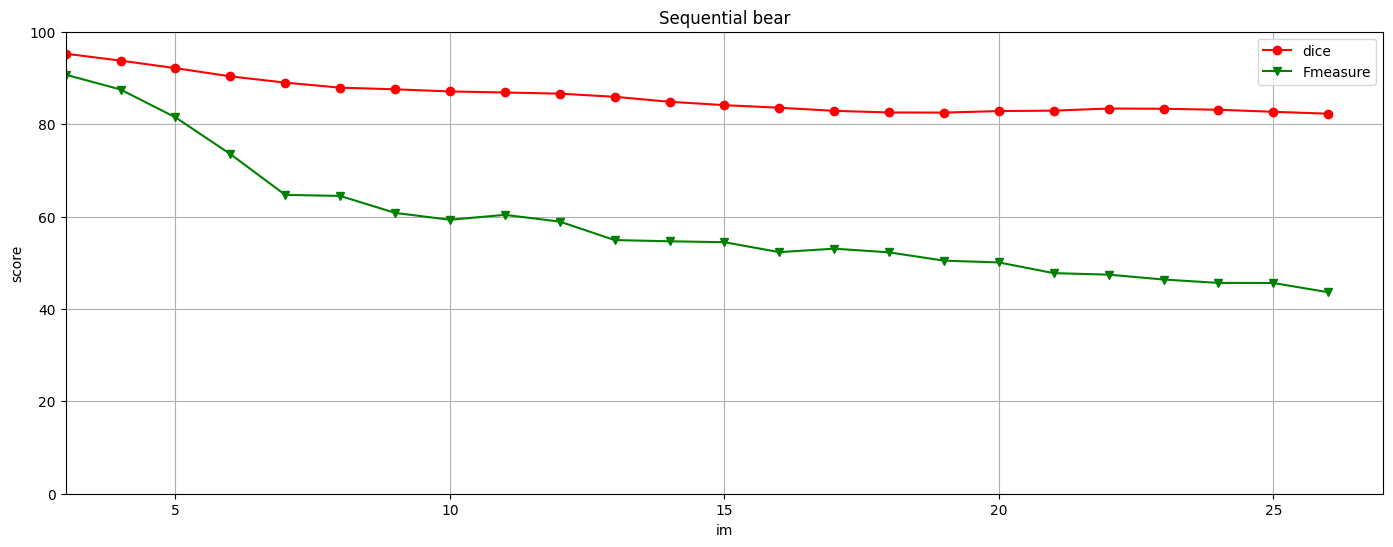

book


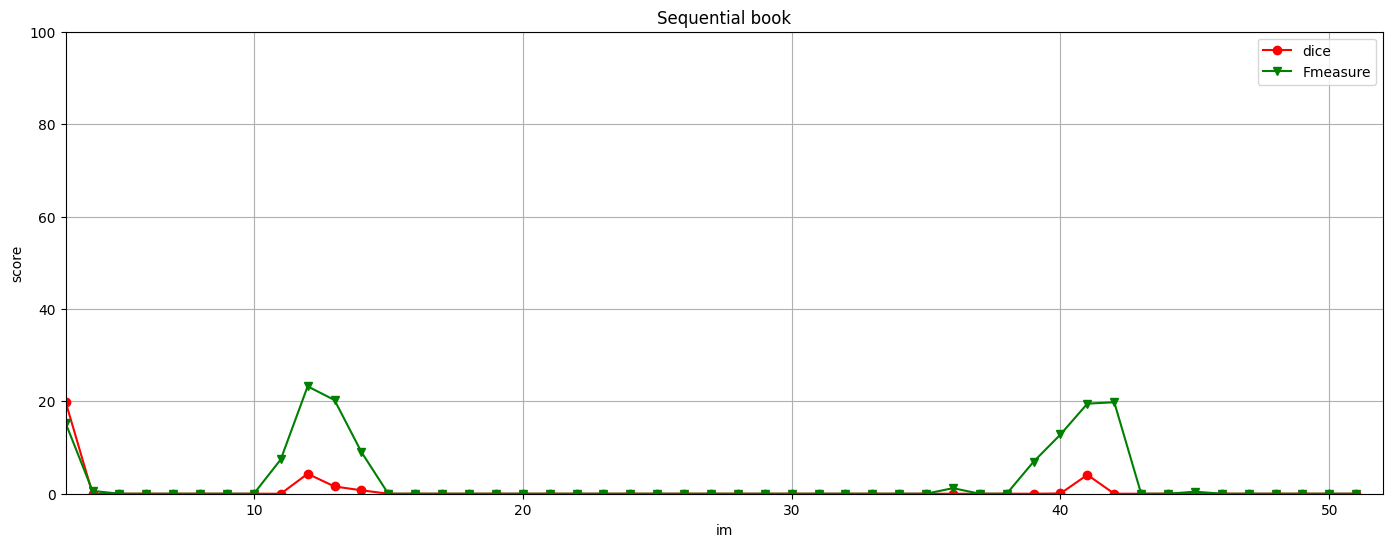

camel


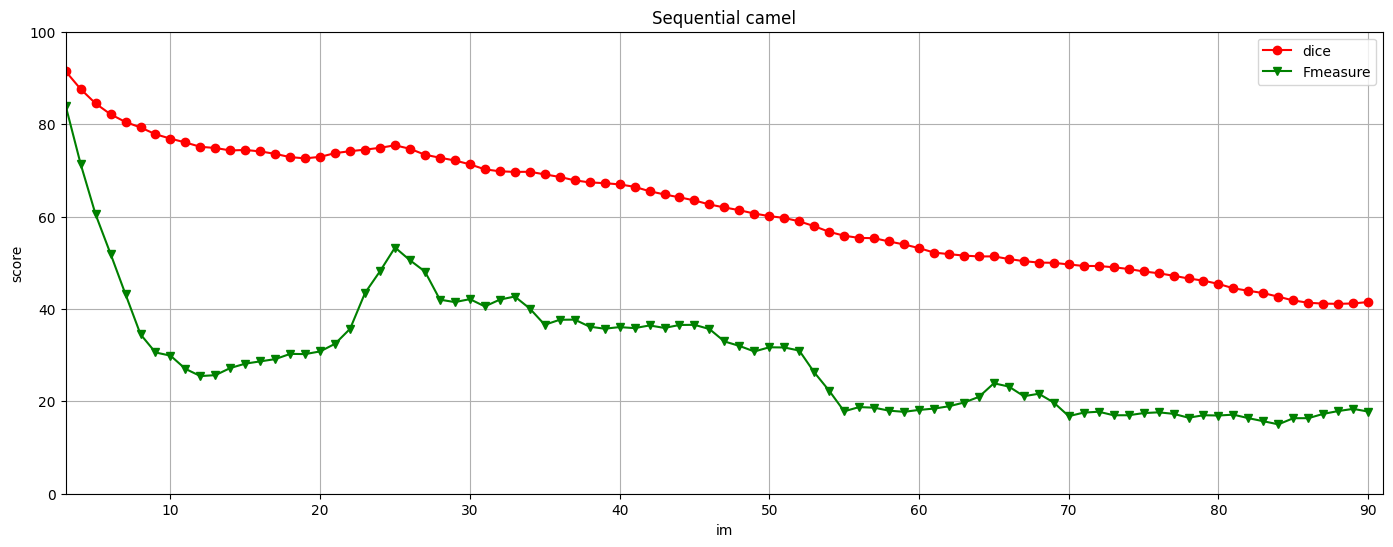

rhino


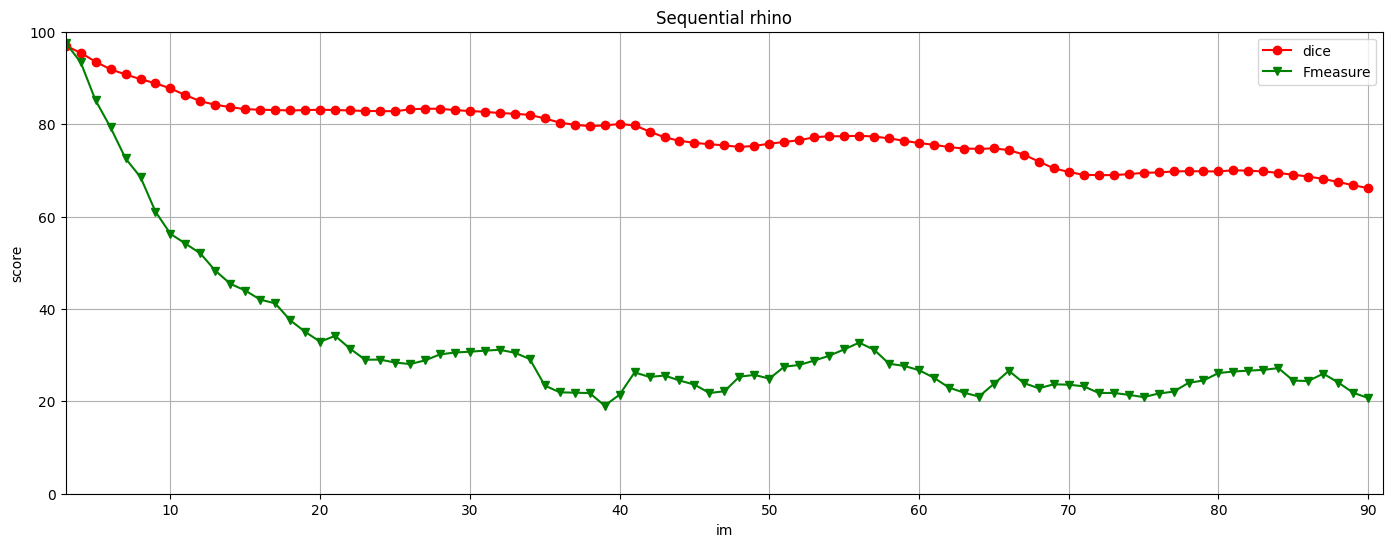

swan


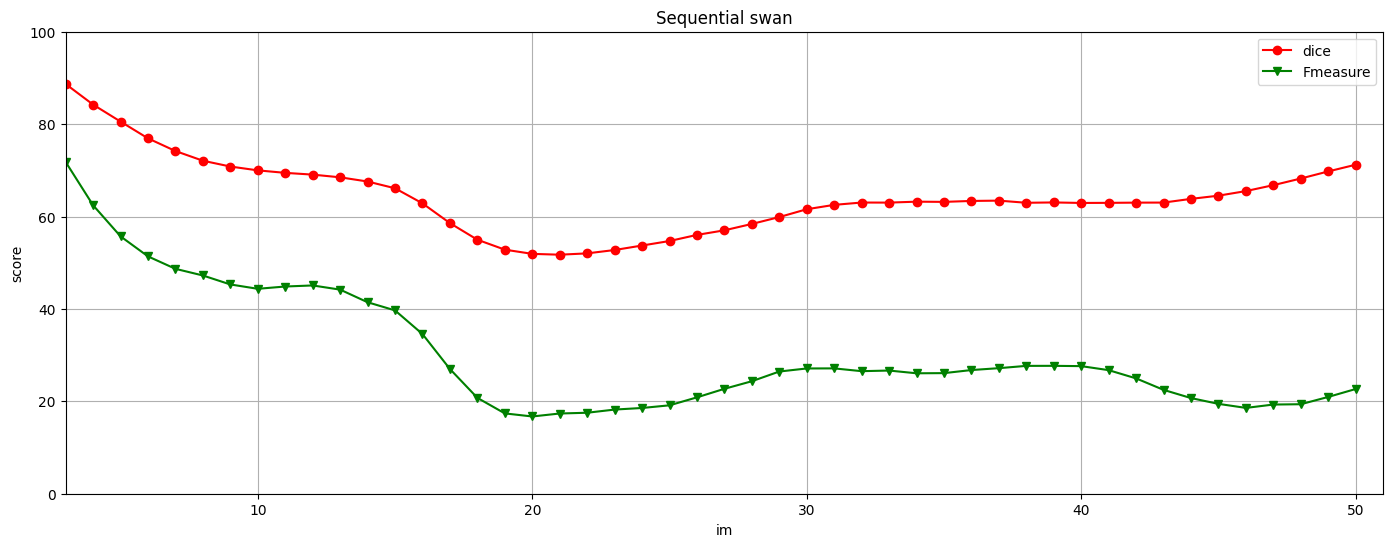

In [45]:
# Results sequential

name = ["bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end =   [ 26    ,  51   , 90     , 90     ,  50]


for i in range(len(name)):
    file_path_dice ="./my_results/"+name[i] +"-dice_seq.npy"
    file_path_fmeasures ="./my_results/"+name[i] +"-fmeasures_seq.npy"

    loaded_array_dice = np.load(file_path_dice)
    loaded_array_fmeasure = np.load(file_path_fmeasures)

    x = range(start[i]+1,end[i]+1)
    print(name[i])
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title("Sequential " + name[i])
    ax.plot(x,loaded_array_dice,marker='o',color='r')
    ax.plot(x,loaded_array_fmeasure,marker='v',color='g')
    ax.set_xlim((start[i]+1+1,end[i]+1))
    ax.set_ylim((0,100))
    ax.set_ylabel('score')
    ax.set_xlabel("im")
    ax.grid()
    ax.legend(['dice', 'Fmeasure'])
    plt.savefig('results_' + name[i] +'.png')
    plt.show()






bear


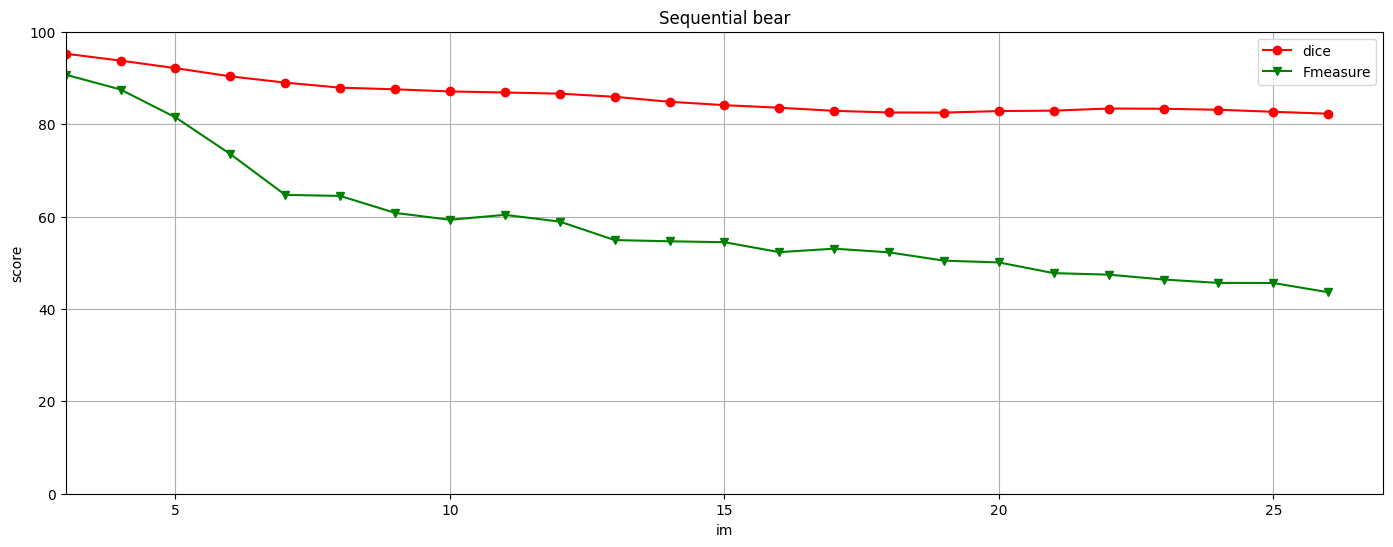

book


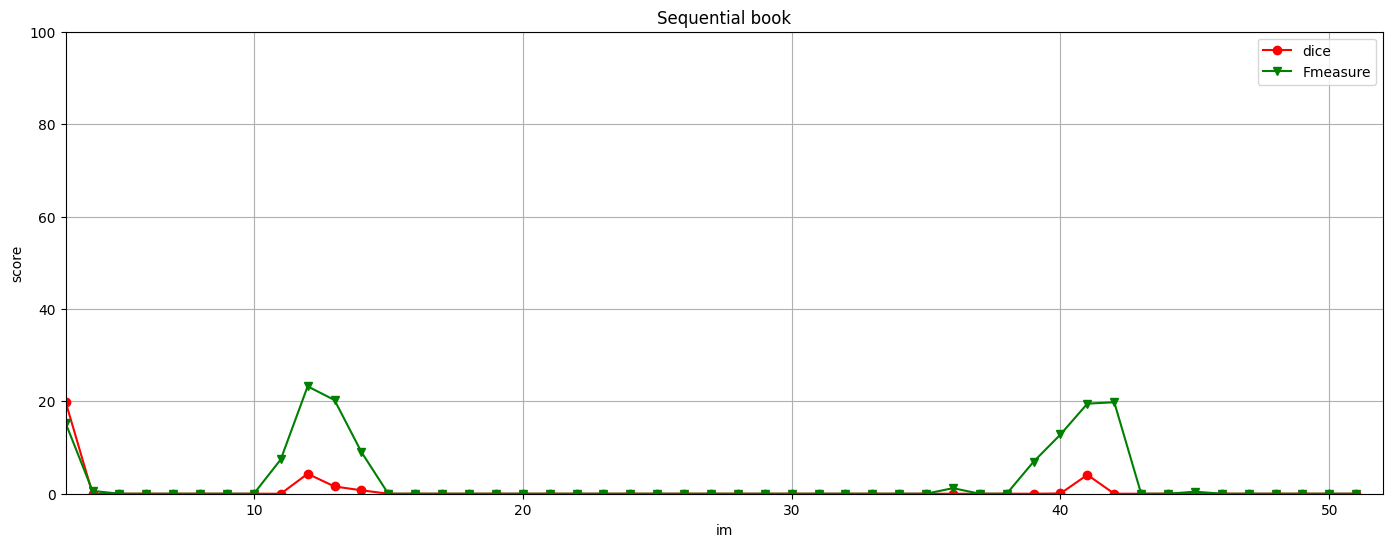

camel


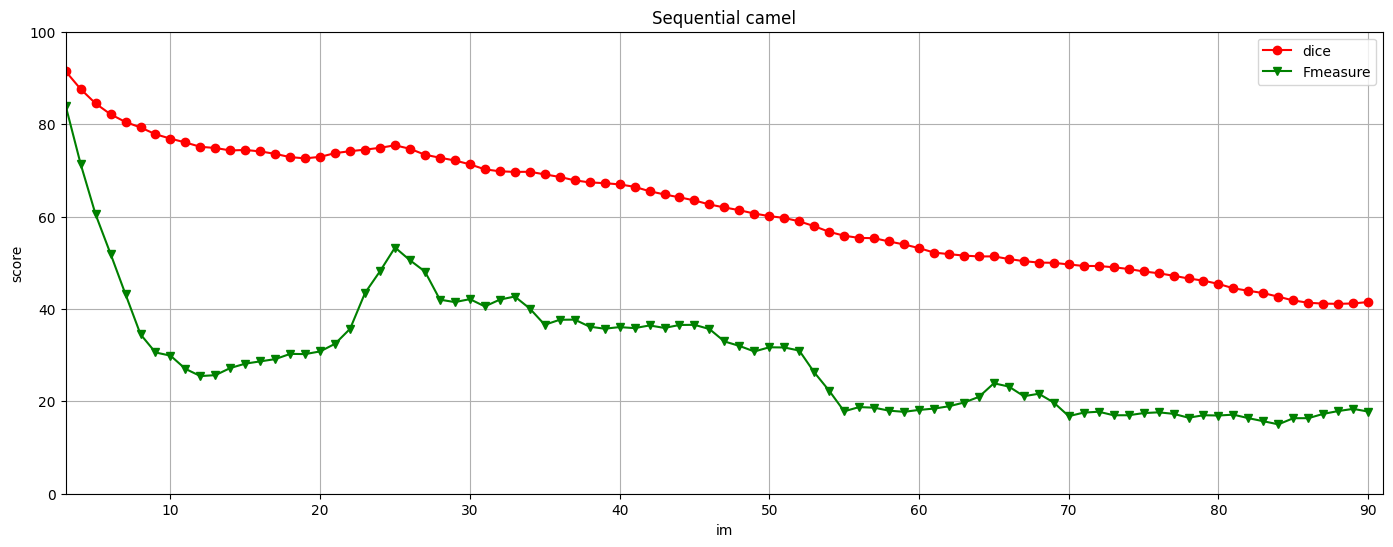

rhino


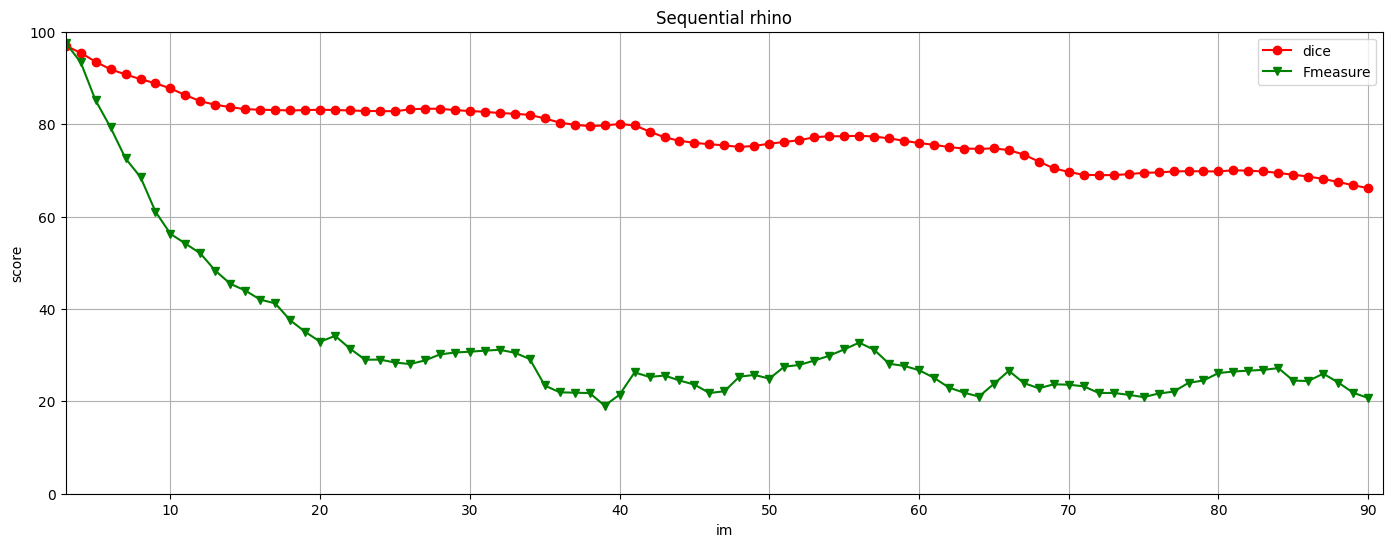

swan


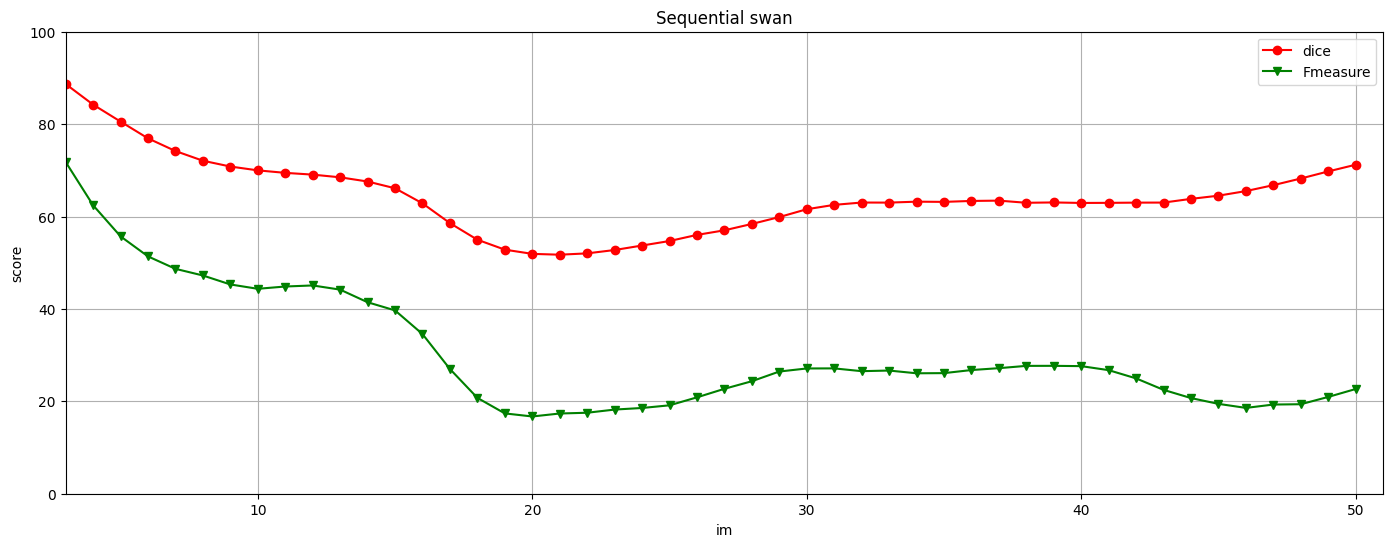

In [46]:
# Results sequential

name = ["bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end =   [ 26    ,  51   , 90     , 90     ,  50]


for i in range(len(name)):
    file_path_dice ="./my_results/"+name[i] +"-dice_seq.npy"
    file_path_fmeasures ="./my_results/"+name[i] +"-fmeasures_seq.npy"

    loaded_array_dice = np.load(file_path_dice)
    loaded_array_fmeasure = np.load(file_path_fmeasures)

    x = range(start[i]+1,end[i]+1)
    print(name[i])
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title("Sequential " + name[i])
    ax.plot(x,loaded_array_dice,marker='o',color='r')
    ax.plot(x,loaded_array_fmeasure,marker='v',color='g')
    ax.set_xlim((start[i]+1+1,end[i]+1))
    ax.set_ylim((0,100))
    ax.set_ylabel('score')
    ax.set_xlabel("im")
    ax.grid()
    ax.legend(['dice', 'Fmeasure'])
    plt.savefig('results_' + name[i] +'.png')
    plt.show()






 **Results Direct integration**

bear


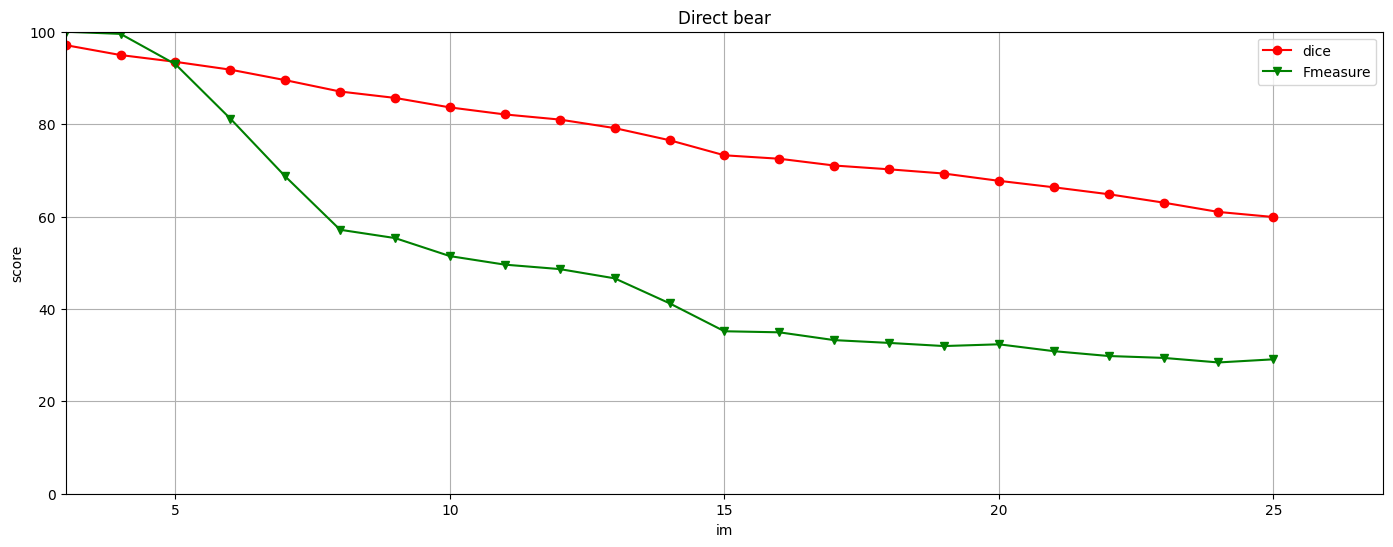

book


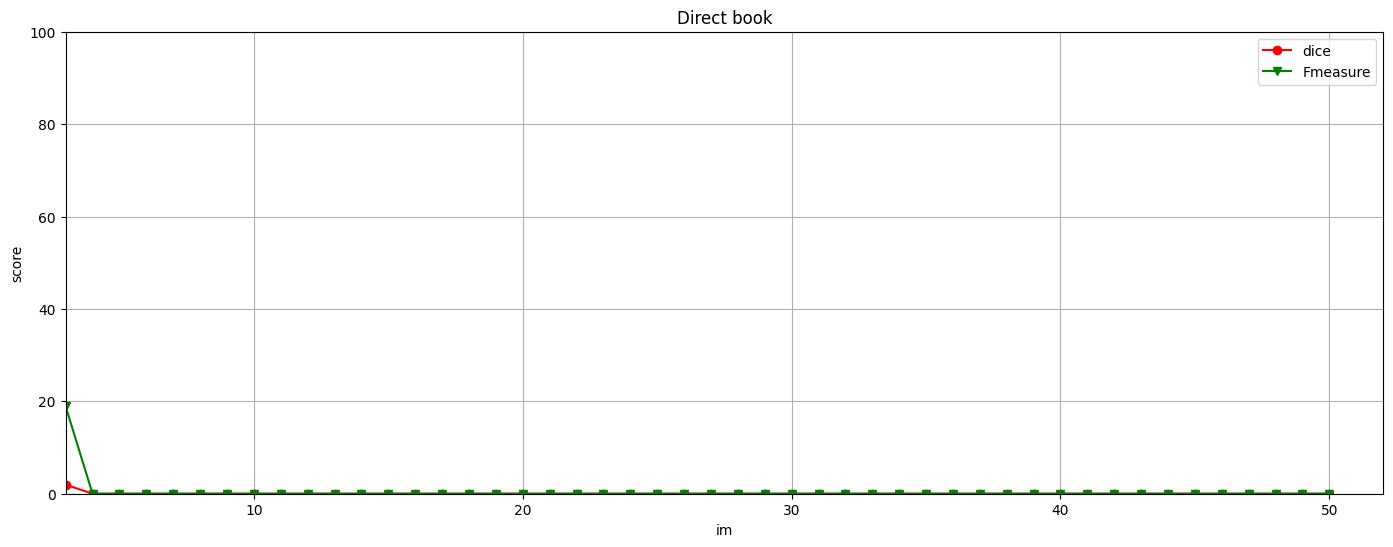

camel


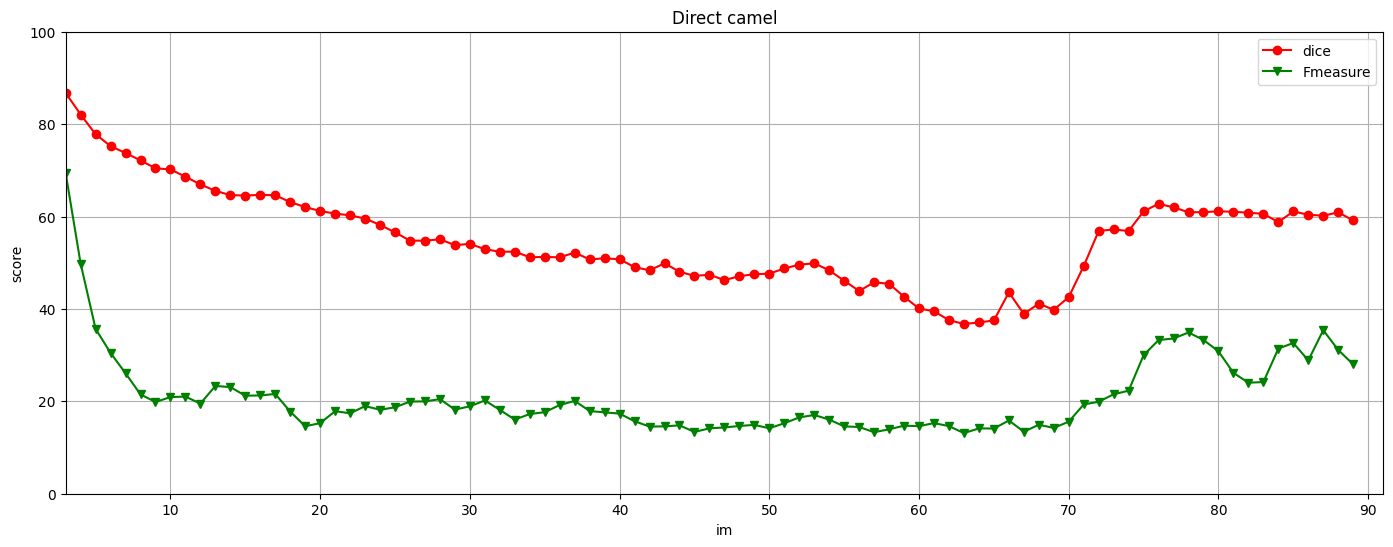

rhino


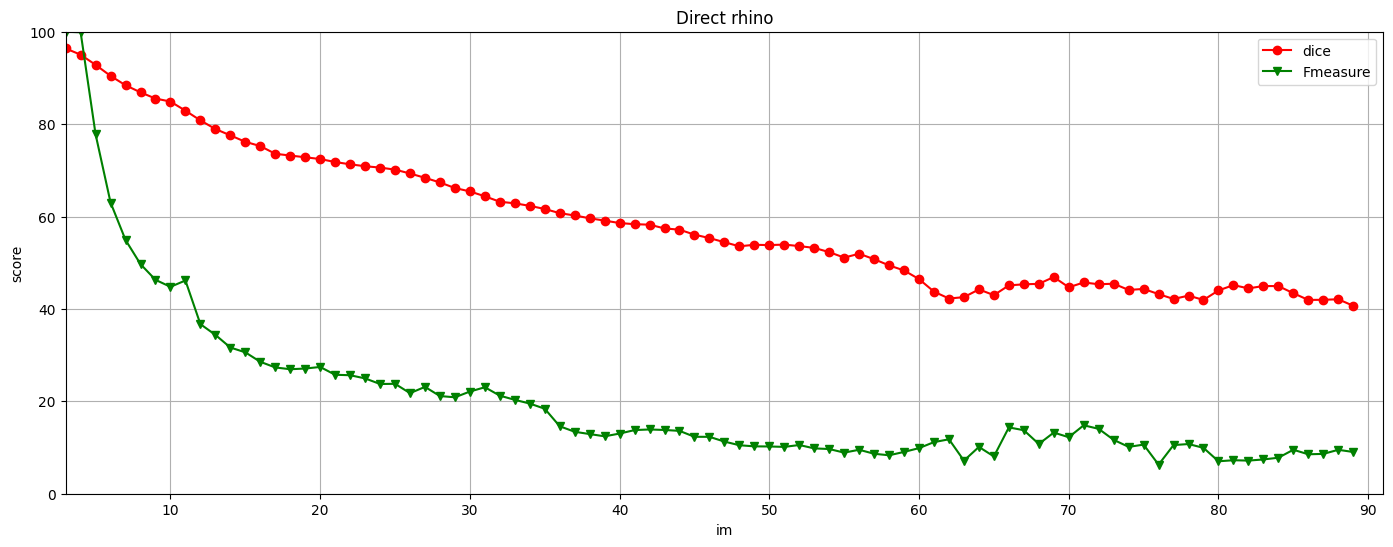

swan


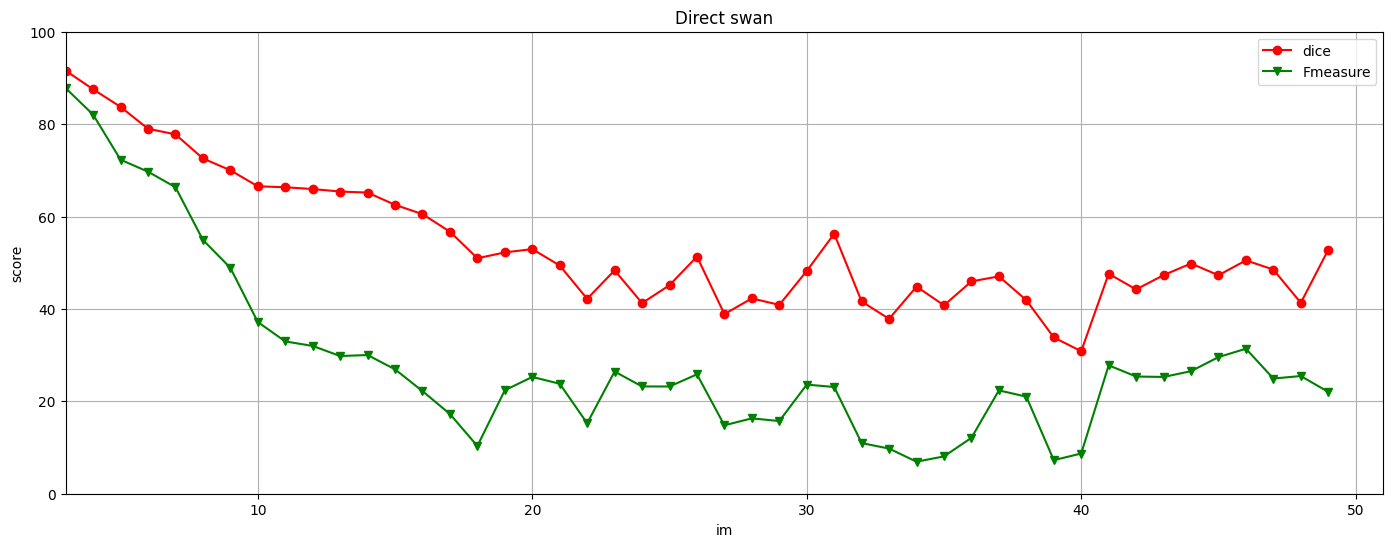

In [47]:
name = ["bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end =   [ 26    ,  51   , 90     , 90     ,  50]


for i in range(len(name)):
    file_path_dice ="./my_results/"+name[i] +"-dice_dir.npy"
    file_path_fmeasures ="./my_results/"+name[i] +"-fmeasures_dir.npy"

    loaded_array_dice = np.load(file_path_dice)
    loaded_array_fmeasure = np.load(file_path_fmeasures)

    x = range(start[i]+1,end[i])
    print(name[i])
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title("Direct " + name[i])
    ax.plot(x,loaded_array_dice,marker='o',color='r')
    ax.plot(x,loaded_array_fmeasure,marker='v',color='g')
    ax.set_xlim((start[i]+1+1,end[i]+1))
    ax.set_ylim((0,100))
    ax.set_ylabel('score')
    ax.set_xlabel("im")
    ax.grid()
    ax.legend(['dice', 'Fmeasure'])
    plt.savefig('results_' + name[i] +'.png')
    plt.show()

book
(49,)
(49,)
(49,)
(49,)
range(1, 50)


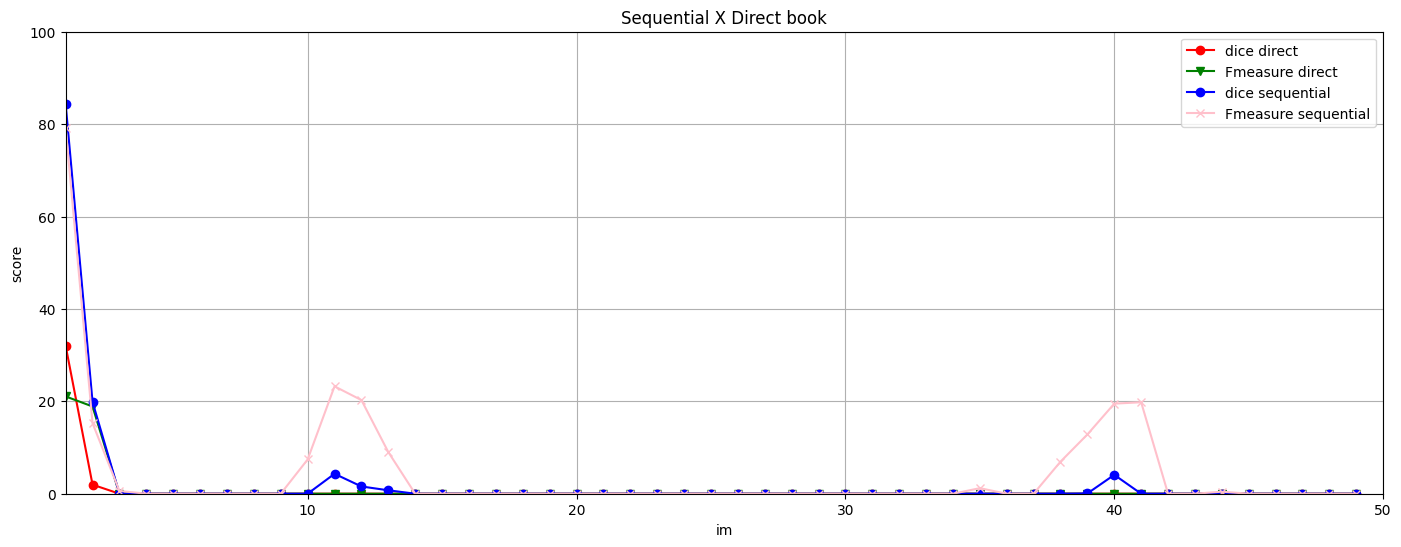

camel
(88,)
(88,)
(88,)
(88,)
range(1, 89)


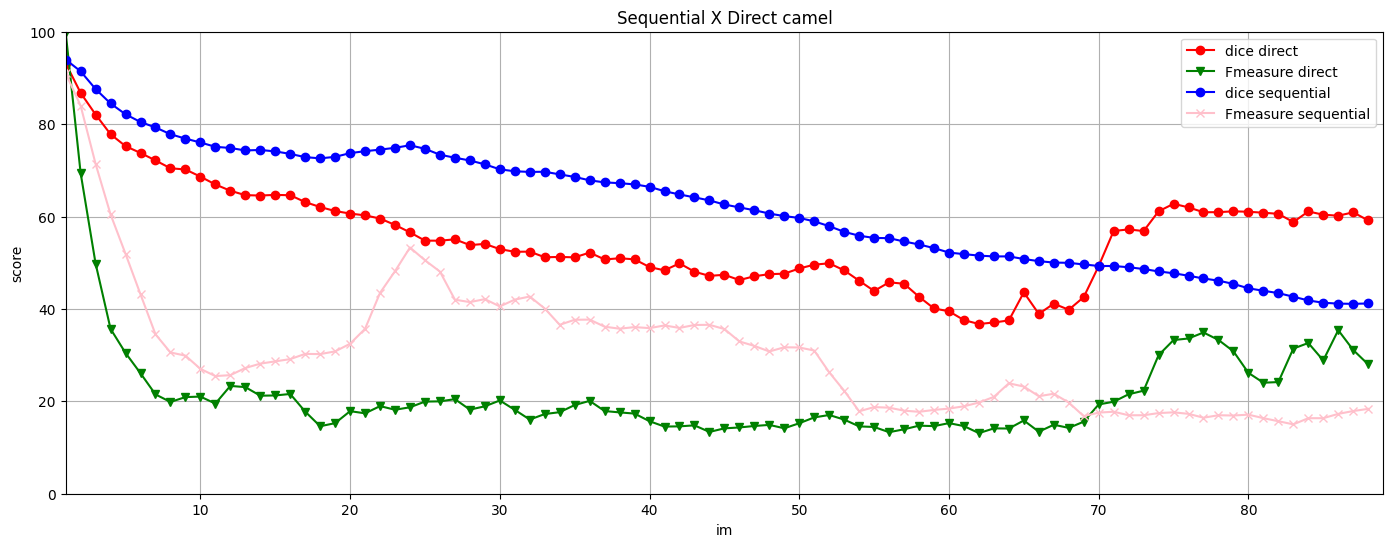

rhino
(88,)
(88,)
(88,)
(88,)
range(1, 89)


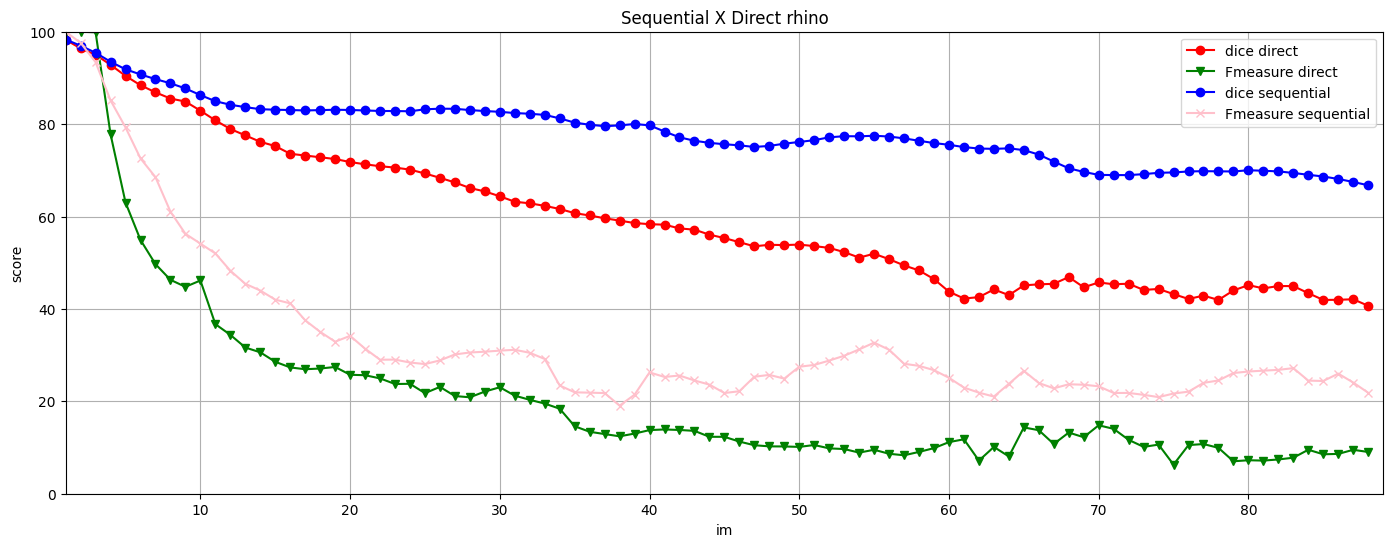

swan
(48,)
(48,)
(48,)
(48,)
range(1, 49)


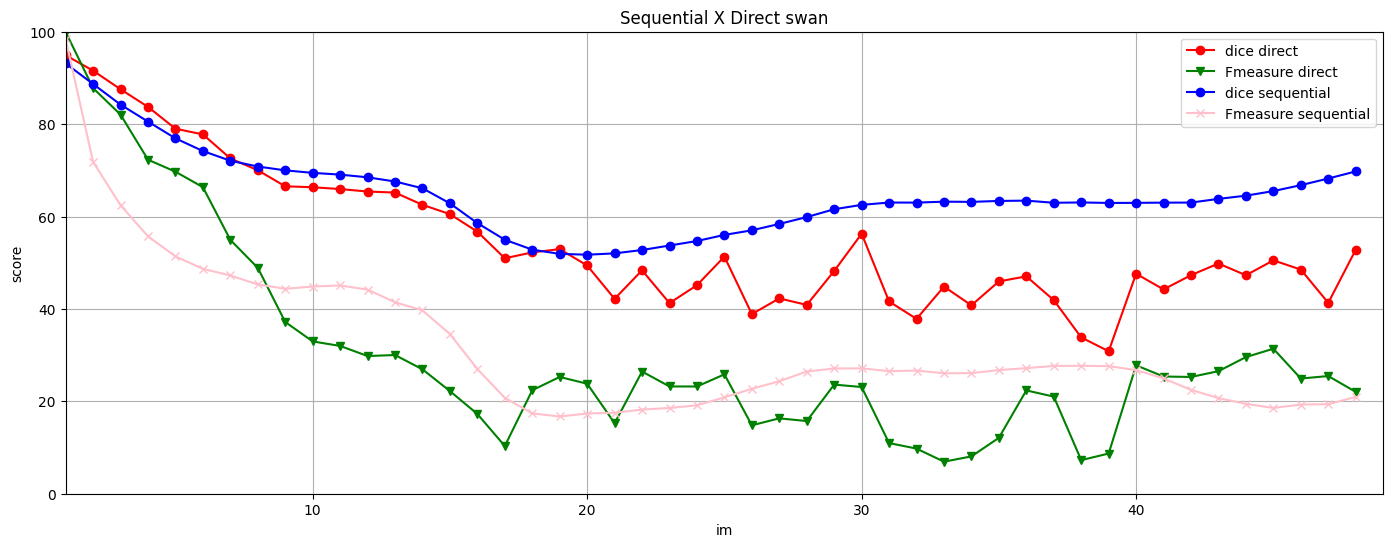

In [48]:
name = [ "book", "camel", "rhino", "swan"]
start = [   1    , 1      , 1      ,  1]  
end =   [  51   , 90     , 90     ,  50]


for i in range(len(name)):

    # direct 
    file_path_dice_d ="./my_results/"+name[i] +"-dice_dir.npy"
    file_path_fmeasures_d ="./my_results/"+name[i] +"-fmeasures_dir.npy"

    loaded_array_dice_d = np.load(file_path_dice_d)
    loaded_array_fmeasure_d = np.load(file_path_fmeasures_d)

    print(name[i])
  

    # sequential
    file_path_dice_s     ="./my_results/"+name[i] +"-dice_seq.npy"
    file_path_fmeasures_s ="./my_results/"+name[i] +"-fmeasures_seq.npy"

    loaded_array_dice_s = np.load(file_path_dice_s)[:-1]
    loaded_array_fmeasure_s = np.load(file_path_fmeasures_s)[:-1]


    print(np.shape(loaded_array_dice_d))
    print(np.shape(loaded_array_fmeasure_d))
    print(np.shape(loaded_array_dice_s))
    print(np.shape(loaded_array_fmeasure_s))

    x = range(start[i],end[i]-1)
    # print(name[i])
    print(x)
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title("Sequential X Direct " + name[i])
    ax.plot(x,loaded_array_dice_d,marker='o',color='r')
    ax.plot(x,loaded_array_fmeasure_d,marker='v',color='g')

    ax.plot(x,loaded_array_dice_s,marker='o',color='b')
    ax.plot(x,loaded_array_fmeasure_s,marker='x',color='pink')
    

    ax.set_xlim((start[i],end[i]-1))
    ax.set_ylim((0,100))
    ax.set_ylabel('score')
    ax.set_xlabel("im")
    ax.grid()
    ax.legend(['dice direct', 'Fmeasure direct ', 'dice sequential ', 'Fmeasure sequential'])
    plt.savefig('results_total_' + name[i] +'.png')
    plt.show()


In [53]:
# generatig gifs 
import imageio


# sequential 
name = ["bear", "book", "camel", "rhino", "swan"]
start = [ 1     ,  1    , 1      , 1      ,  1]  
end =   [ 26    ,  51   , 90     , 90     ,  50]


j = 3 # rhino
rhino_seq_gif = []
rhino_dir_gif = []
rhino_gd_gif = []
for j in range(start[j]+1, end[j]):
    rhino_seq_gif.append(imread("./my_results/rhino-mask_pro_sequential"+ str(j).zfill(3) +'.png'))
    rhino_dir_gif.append(imread("./my_results/rhino-mask_pro_dir-001-"+ str(j).zfill(3) +'.png'))
    rhino_gd_gif.append(imread("./sequences-train/" + name[3]+ "-"+ str(j).zfill(3) + ".png"))


# imageio.mimsave('rhino_seq.gif', rhino_seq_gif)
# imageio.mimsave('rhino_dir.gif', rhino_dir_gif)
# imageio.mimsave('rhino_gd.gif', rhino_gd_gif)


<Figure size 640x480 with 0 Axes>

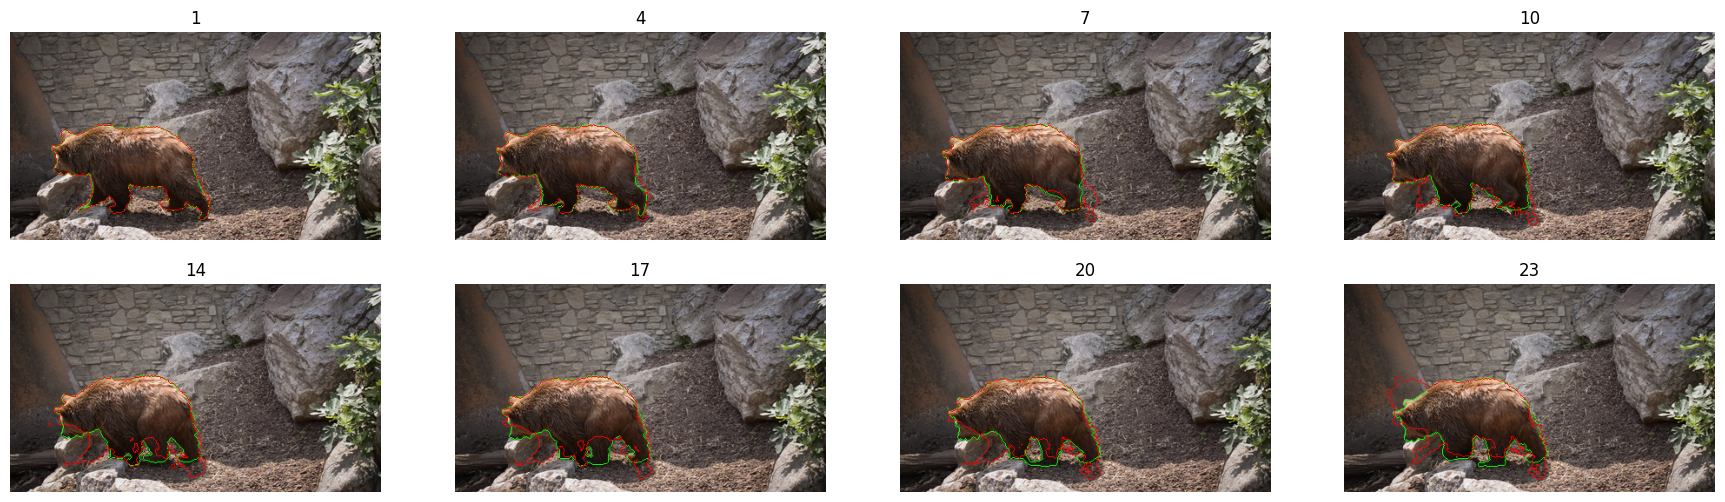

In [97]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(visu[im])
    plt.title('%i' %(im+1))
plt.show()

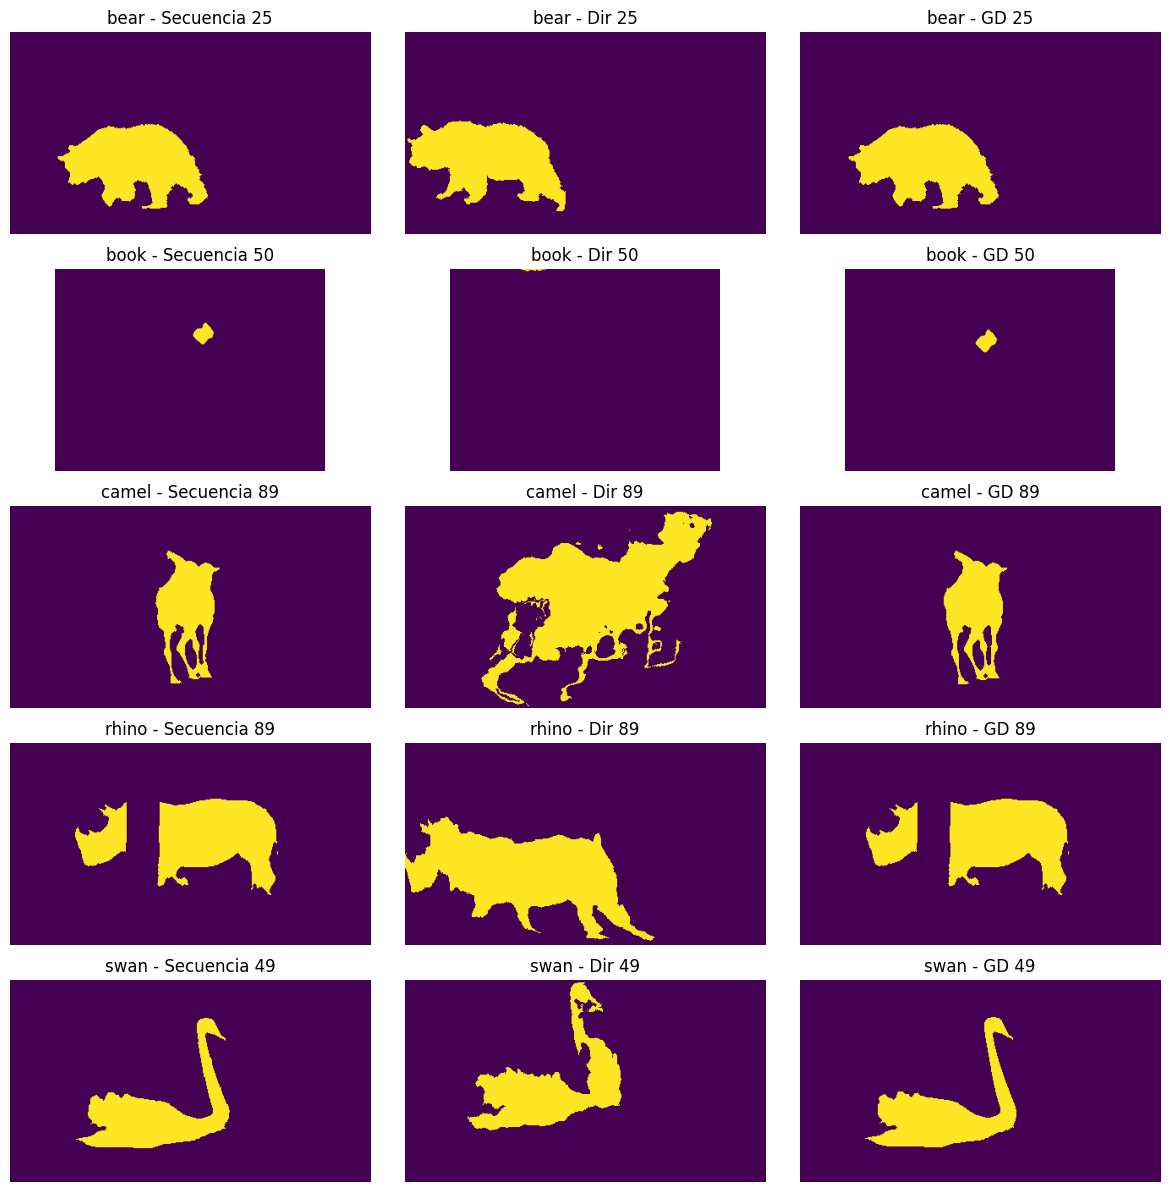

In [59]:
from matplotlib import gridspec
name = ["bear", "book", "camel", "rhino", "swan"]
start = [2,2,2,2,2]  
end = [26, 51, 90, 90, 50]

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(len(name), 3, width_ratios=[1, 1, 1])  # Tres columnas: Secuencia, Dirección y Imagen

# Iterar sobre todos los elementos
for idx, n in enumerate(name):
    rhino_seq_gif = []
    rhino_dir_gif = []
    rhino_gd_gif = []
    
    for j in range(start[idx], end[idx]):  # Cambiar rango según cada secuencia
        rhino_seq_gif.append(imread(f"./my_results/{n}-mask_pro_sequential{str(j).zfill(3)}.png"))
        rhino_dir_gif.append(imread(f"./my_results/{n}-mask_pro_dir-001-{str(j).zfill(3)}.png"))
        rhino_gd_gif.append(imread(f"./sequences-train/{n}-{str(j).zfill(3)}.png"))
        
        # Mostrar imágenes en el gráfico
        ax1 = plt.subplot(gs[idx, 0])  # Primer columna: Secuencia
        ax1.imshow(rhino_seq_gif[-1])  # Última imagen de la secuencia
        ax1.set_title(f"{n} - Secuencia {j}")
        ax1.axis('off')
        
        ax2 = plt.subplot(gs[idx, 1])  # Segunda columna: Dirección
        ax2.imshow(rhino_dir_gif[-1])  # Última imagen de dirección
        ax2.set_title(f"{n} - Dir {j}")
        ax2.axis('off')
        
        ax3 = plt.subplot(gs[idx, 2])  # Tercer columna: Imagen original
        ax3.imshow(rhino_gd_gif[-1])  # Última imagen original
        ax3.set_title(f"{n} - GD {j}")
        ax3.axis('off')

plt.tight_layout()
plt.show()